# Training a binary image classifier for deepfakes

Earlier I published [this kernel](https://www.kaggle.com/humananalog/inference-demo) that shows how to do inference on the Deepfakes competition. It includes a ResNeXt50 checkpoint that I trained on my own machine and that gets 0.46788 on the leaderboard.

I did not include code for training that ResNeXt50 model because my process involves running a bunch of different scripts to create and clean up a training set, amongst other things. It's not feasible to do all of this in a Kaggle kernel.

However, Kaggler [dagnelies](https://www.kaggle.com/dagnelies) has made [this dataset of face crops](https://www.kaggle.com/dagnelies/deepfake-faces) available. Using this dataset, we can actually train our model using a Kaggle kernel!

**Tip:** Enable GPU for this. It's *really slow* using CPU.

In [1]:
import os, sys, random
import numpy as np
import pandas as pd
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure, img_as_ubyte
from skimage import data, io, filters

In [2]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [3]:
image_size = 224
batch_size = 64

## The data

You need a bunch of face crops that are extracted from the full training dataset. Because we can't use the full training data from a kernel, I'm using [this dataset](https://www.kaggle.com/dagnelies/deepfake-faces), which is a nice starting point. You'll probably want to create your own dataset of face crops, as the quality of your training data makes all the difference.

In [4]:
crops_dir = "./data/faces_224"
hog_dir = "./data/hog_faces_224"
hogv2_dir = "./data/hog2_faces_224"
metadata_df = pd.read_csv("./data/metadata.csv")
metadata_df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [6]:
len(metadata_df)

95634

How many faces of each class do we have?

In [7]:
len(metadata_df[metadata_df.label == "REAL"]), len(metadata_df[metadata_df.label == "FAKE"])

(16293, 79341)

Look at a random face image:

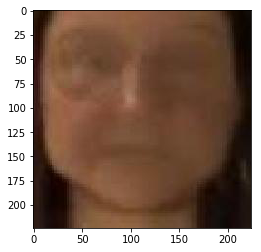

In [5]:
img_path = os.path.join(crops_dir, np.random.choice(os.listdir(hog_dir)))
plt.imshow(cv2.imread(img_path)[..., ::-1])

## Creating a HOG augumented dataset

(224, 224, 3)


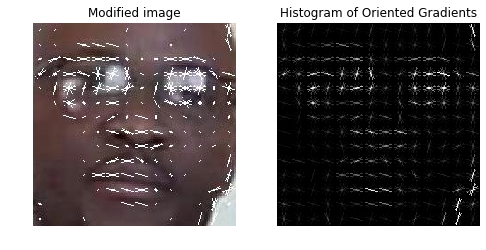

In [87]:
face_images = os.listdir(crops_dir)
for img_name in face_images:
    img = cv2.imread(os.path.join(crops_dir, img_name))
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True, multichannel=True)
    hog_image_rescaled = img_as_ubyte(exposure.rescale_intensity(hog_image, in_range=(0, 10)))
    for i in range(224):
        for j in range(224):
            if hog_image_rescaled[i][j]>50:
                img[i,j,:] = 255
    io.imsave(os.path.join(hogv2_dir, img_name),img)
    # hog_image_2 = cv2.imread(os.path.join(hogv2_dir, img_name))
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    # ax1.axis('off')
    # ax1.imshow(hog_image_2, cmap=plt.cm.gray)
    # ax1.set_title('Modified image')
    # ax2.axis('off')
    # ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    # ax2.set_title('Histogram of Oriented Gradients')
    # plt.show()
    # break

In [6]:
crops_dir = hogv2_dir #comment this for removing this feature

## The dataset and data loaders

Like most other torchvision models, the model we're using (ResNeXt50) requires that input images are normalized using mean and stddev. For making plots, we also define an "unnormalize" transform that can take a normalized image and turn it back into regular pixels.

In [7]:
from torchvision.transforms import Normalize

class Unnormalize:
    """Converts an image tensor that was previously Normalize'd
    back to an image with pixels in the range [0, 1]."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor*std + mean, 0., 1.)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)
unnormalize_transform = Unnormalize(mean, std)

During training, we'll apply data augmentation. In this kernel we just do random horizontal flips, but you can add other image transformations here too, such as rotation, zooming, etc. It's possible to use torchvision transforms for this, or a library such as [imgaug](https://www.github.com/aleju/imgaug), but I rolled my own using OpenCV2.

In [8]:
def random_hflip(img, p=0.5):
    """Random horizontal flip."""
    if random.random() < p:
        return cv2.flip(img, 1)
    else:
        return img

Some helper code for loading a training image and its label:

In [9]:
def load_image_and_label(filename, cls, crops_dir, image_size, augment):
    """Loads an image into a tensor. Also returns its label."""
    img = cv2.imread(os.path.join(crops_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if augment: 
        img = random_hflip(img)

    img = cv2.resize(img, (image_size, image_size))

    img = torch.tensor(img).permute((2, 0, 1)).float().div(255)
    img = normalize_transform(img)

    target = 1 if cls == "FAKE" else 0
    return img, target

It's always smart to test that the code actually works. The following cell should return a normalized PyTorch tensor of shape (3, 224, 224) and the target 1 (for fake).

Note that this dataset has 155x155 images but our model needs at least 224x224, so we resize them.

In [10]:
img, target = load_image_and_label("aabuyfvwrh.jpg", "FAKE", crops_dir, 224, augment=True)
img.shape, target

(torch.Size([3, 224, 224]), 1)

To plot the image, we need to unnormalize it and also permute it from (3, 224, 224) to (224, 224, 3). 

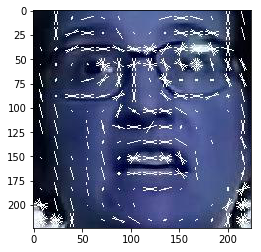

In [11]:
plt.imshow(unnormalize_transform(img).permute((1, 2, 0)))

To use the PyTorch data loader, we need to create a `Dataset` object.

Because of the class imbalance (many more fakes than real videos), we're using a dataset that samples a given number of REAL faces and the same number of FAKE faces, so it's always 50-50.

In [12]:
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    """Face crops dataset.

    Arguments:
        crops_dir: base folder for face crops
        df: Pandas DataFrame with metadata
        split: if "train", applies data augmentation
        image_size: resizes the image to a square of this size
        sample_size: evenly samples this many videos from the REAL
            and FAKE subfolders (None = use all videos)
        seed: optional random seed for sampling
    """
    def __init__(self, crops_dir, df, split, image_size, sample_size=None, seed=None):
        self.crops_dir = crops_dir
        self.split = split
        self.image_size = image_size
        
        if sample_size is not None:
            real_df = df[df["label"] == "REAL"]
            fake_df = df[df["label"] == "FAKE"]
            sample_size = np.min(np.array([sample_size, len(real_df), len(fake_df)]))
            print("%s: sampling %d from %d real videos" % (split, sample_size, len(real_df)))
            print("%s: sampling %d from %d fake videos" % (split, sample_size, len(fake_df)))
            real_df = real_df.sample(sample_size, random_state=seed)
            fake_df = fake_df.sample(sample_size, random_state=seed)
            self.df = pd.concat([real_df, fake_df])
        else:
            self.df = df

        num_real = len(self.df[self.df["label"] == "REAL"])
        num_fake = len(self.df[self.df["label"] == "FAKE"])
        print("%s dataset has %d real videos, %d fake videos" % (split, num_real, num_fake))

    def __getitem__(self, index):
        row = self.df.iloc[index]
        filename = row["videoname"][:-4] + ".jpg"
        cls = row["label"]
        return load_image_and_label(filename, cls, self.crops_dir, 
                                    self.image_size, self.split == "train")
    def __len__(self):
        return len(self.df)

Let's test that the dataset actually works...

In [13]:
dataset = VideoDataset(crops_dir, metadata_df, "val", image_size, sample_size=1000, seed=1234)

val: sampling 1000 from 16293 real videos
val: sampling 1000 from 79341 fake videos
val dataset has 1000 real videos, 1000 fake videos


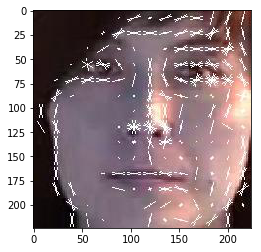

In [14]:
plt.imshow(unnormalize_transform(dataset[0][0]).permute(1, 2, 0))

In [15]:
del dataset

Split up the data into train / validation. There are many different ways to do this. For this kernel, we're going to just grab a percentage of the REAL faces as well as their corresponding FAKEs. This way, a real video and all the fakes that are derived from it will be either completely in the training set or completely in the validation set. 

(This is still not ideal because the same person may appear in many different videos. Ideally we want a person to be either in train or in val, but not in both. But it will do for now.)

In [16]:
def make_splits(crops_dir, metadata_df, frac):
    # Make a validation split. Sample a percentage of the real videos, 
    # and also grab the corresponding fake videos.
    real_rows = metadata_df[metadata_df["label"] == "REAL"]
    real_df = real_rows.sample(frac=frac, random_state=666)
    fake_df = metadata_df[metadata_df["original"].isin(real_df["videoname"])]
    val_df = pd.concat([real_df, fake_df])

    # The training split is the remaining videos.
    train_df = metadata_df.loc[~metadata_df.index.isin(val_df.index)]

    return train_df, val_df

Sanity check:

In [17]:
train_df, val_df = make_splits(crops_dir, metadata_df, frac=0.05)

assert(len(train_df) + len(val_df) == len(metadata_df))
assert(len(train_df[train_df["videoname"].isin(val_df["videoname"])]) == 0)

del train_df, val_df

Use all of the above building blocks to create `DataLoader` objects. Note that we use only a portion of the full amount of training data, for speed reasons. If you have more patience, increase the `sample_size`.

In [18]:
from torch.utils.data import DataLoader

def create_data_loaders(crops_dir, metadata_df, image_size, batch_size, num_workers):
    train_df, val_df = make_splits(crops_dir, metadata_df, frac=0.05)

    train_dataset = VideoDataset(crops_dir, train_df, "train", image_size, sample_size=10000)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True)

    val_dataset = VideoDataset(crops_dir, val_df, "val", image_size, sample_size=500, seed=1234)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

In [19]:
train_loader, val_loader = create_data_loaders(crops_dir, metadata_df, image_size, 
                                               batch_size, num_workers=2)

train: sampling 10000 from 15478 real videos
train: sampling 10000 from 75449 fake videos
train dataset has 10000 real videos, 10000 fake videos
val: sampling 500 from 815 real videos
val: sampling 500 from 3892 fake videos
val dataset has 500 real videos, 500 fake videos


In [ ]:
And, as usual, a check that it works... The `train_loader` should give a different set of examples each time you run it (because `shuffle=True`), while the `val_loader` always returns the examples in the same order.

tensor(1)


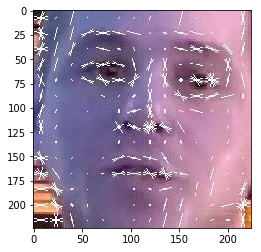

In [20]:
X, y = next(iter(train_loader))
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
print(y[0])

tensor(0)


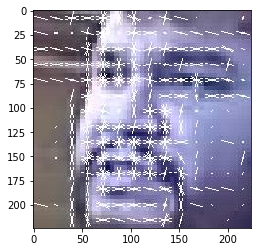

In [21]:
X, y = next(iter(val_loader))
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
print(y[0])

## Helper code for training

Evaluation function for running the model on the validation set:

In [22]:
def evaluate(net, data_loader, device, silent=False):
    net.train(False)

    bce_loss = 0
    total_examples = 0

    with tqdm(total=len(data_loader), desc="Evaluation", leave=False, disable=silent) as pbar:
        for batch_idx, data in enumerate(data_loader):
            with torch.no_grad():
                batch_size = data[0].shape[0]
                x = data[0].to(device)
                y_true = data[1].to(device).float()

                y_pred = net(x)
                y_pred = y_pred.squeeze()

                bce_loss += F.binary_cross_entropy_with_logits(y_pred, y_true).item() * batch_size

            total_examples += batch_size
            pbar.update()

    bce_loss /= total_examples

    if silent:
        return bce_loss
    else:
        print("BCE: %.4f" % (bce_loss))

Simple training loop. I prefer to write those myself from scratch each time, because then you can tweak it to do whatever you like.

In [23]:
def fit(epochs):
    global history, iteration, epochs_done, lr

    with tqdm(total=len(train_loader), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done + 1))
            
            bce_loss = 0
            total_examples = 0

            net.train(True)

            for batch_idx, data in enumerate(train_loader):
                batch_size = data[0].shape[0]
                x = data[0].to(gpu)
                y_true = data[1].to(gpu).float()
                
                optimizer.zero_grad()

                y_pred = net(x)
                y_pred = y_pred.squeeze()
                
                loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
                loss.backward()
                optimizer.step()
                
                batch_bce = loss.item()
                bce_loss += batch_bce * batch_size
                history["train_bce"].append(batch_bce)

                total_examples += batch_size
                iteration += 1
                pbar.update()

            bce_loss /= total_examples
            epochs_done += 1

            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))
            #wandb.log({"bce_loss": bce_loss, "epoc": epoch})

            val_bce_loss = evaluate(net, val_loader, device=gpu, silent=True)
            history["val_bce"].append(val_bce_loss)
            
            print("val BCE: %.4f" % (val_bce_loss))

            # TODO: can do LR annealing here
            # TODO: can save checkpoint here

            print("")

## The model

Need to load pretrained ImageNet weights into the model.

You can get these weights from `https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth`, or from [this dataset](https://www.kaggle.com/tony92151/pretrained-pytorch) by Kaggler [tonyguo](https://www.kaggle.com/tony92151).

In [24]:
import torchvision

In [52]:
checkpoint = torchvision.models.resnext50_32x4d(pretrained=True)

In [53]:
checkpoint = checkpoint.state_dict()

In [55]:
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)

        self.load_state_dict(checkpoint)
        #self.layer4 = nn.Sequential(nn.Dropout(0.8), self.layer4.0)
        # Override the existing FC layer with a new one.
        self.fc = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(2048, 1)
)

In [56]:
net = MyResNeXt().to(gpu)

In [57]:
del checkpoint

Test the model on a small batch to see what its output shape is:

In [58]:
out = net(torch.zeros((10, 3, image_size, image_size)).to(gpu))
out.shape

torch.Size([10, 1])

Freeze the early layers of the model:

In [31]:
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

In [60]:
freeze_until(net, "layer4.0.conv1.weight")

These are the layers we will train:

In [51]:
[k for k,v in net.named_parameters() if v.requires_grad]

['layer4.0.conv1.weight',
 'layer4.0.bn1.weight',
 'layer4.0.bn1.bias',
 'layer4.0.conv2.weight',
 'layer4.0.bn2.weight',
 'layer4.0.bn2.bias',
 'layer4.0.conv3.weight',
 'layer4.0.bn3.weight',
 'layer4.0.bn3.bias',
 'layer4.0.downsample.0.weight',
 'layer4.0.downsample.1.weight',
 'layer4.0.downsample.1.bias',
 'layer4.1.conv1.weight',
 'layer4.1.bn1.weight',
 'layer4.1.bn1.bias',
 'layer4.1.conv2.weight',
 'layer4.1.bn2.weight',
 'layer4.1.bn2.bias',
 'layer4.1.conv3.weight',
 'layer4.1.bn3.weight',
 'layer4.1.bn3.bias',
 'layer4.2.conv1.weight',
 'layer4.2.bn1.weight',
 'layer4.2.bn1.bias',
 'layer4.2.conv2.weight',
 'layer4.2.bn2.weight',
 'layer4.2.bn2.bias',
 'layer4.2.conv3.weight',
 'layer4.2.bn3.weight',
 'layer4.2.bn3.bias',
 'fc.1.weight',
 'fc.1.bias']

Before we train, let's run the model on the validation set. This should give a logloss of about 0.6931.

In [41]:
evaluate(net, val_loader, device=gpu)

BCE: 0.7064


## Training

In [61]:
lr = 0.01
wd = 0.

history = { "train_bce": [], "val_bce": [] }
iteration = 0
epochs_done = 0

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

At this point you can load the model from the previous checkpoint. If you do, also make sure to restore the optimizer state! Something like this:

```python
checkpoint = torch.load("model-checkpoint.pth")
net.load_state_dict(checkpoint)

checkpoint = torch.load("optimizer-checkpoint.pth")
optimizer.load_state_dict(checkpoint)
```

Let's start training!

In [69]:
fit(1)

Epoch:   7, train BCE: 0.3068
val BCE: 0.6346



Manual learning rate annealing:

In [83]:
def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [84]:
lr = 1e-4
set_lr(optimizer, lr)

Plot training progress. It's nicer to use something like TensorBoard for this, but a simple plot also works. ;-)

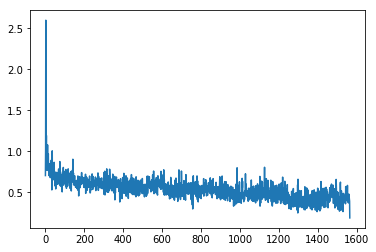

In [63]:
plt.plot(history["train_bce"])

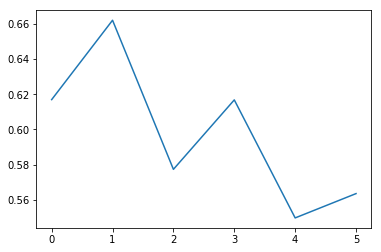

In [67]:
plt.plot(history["val_bce"])

**All done!** You can now use this checkpoint in the [inference kernel](https://www.kaggle.com/humananalog/inference-demo).

In [68]:
torch.save(net.state_dict(), "image-classifier-hog-checkpoint.pth")
